In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce
from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_excel("C:/Users/koray/PycharmProjects/pythonProject/DATA SETS/yl11_dataset.xlsx")

In [4]:
df.head()

,su,klorofil miktarı,bitki örtü sıcaklığı,yaprak sap uzunluğu,yaprak ağırlığı
0,0,45.700,33.000,3.300,8.200
1,0,34.600,32.000,3.400,10.400
2,0,39.500,42.000,3.500,11.400
3,0,38.600,33.000,4.100,13.700
4,0,39.100,32.000,3.500,13.100


In [5]:
df.isnull().sum()

su                      0
klorofil miktarı        0
bitki örtü sıcaklığı    0
yaprak sap uzunluğu     0
yaprak ağırlığı         0
dtype: int64

In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, cat_but_car, num_cols

In [7]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [8]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [9]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [10]:
cat_cols, cat_but_car, num_cols = grab_col_names(df)

Observations: 2115
Variables: 5
cat_cols: 1
num_cols: 4
cat_but_car: 0
num_but_cat: 1


In [11]:
for col in num_cols:
    replace_with_thresholds(df, col)

In [12]:
df.head()

,su,klorofil miktarı,bitki örtü sıcaklığı,yaprak sap uzunluğu,yaprak ağırlığı
0,0,45.700,33.000,3.300,8.200
1,0,34.600,32.000,3.400,10.400
2,0,39.500,42.000,3.500,11.400
3,0,38.600,33.000,4.100,13.700
4,0,39.100,32.000,3.500,13.100


In [13]:
X = df.drop(columns=["su"])
y = df["su"]

sampling_strategy = {0: 2250, 1: 2250, 2: 2250, 3:2250, 4:2250, 5:2250, 6:2250}

smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Orijinal veri sınıf dağılımı:", Counter(y))
print("SMOTE sonrası sınıf dağılımı:", Counter(y_resampled))

df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["su"])], axis=1)
print(df_resampled)

Orijinal veri sınıf dağılımı: Counter({0: 303, 1: 303, 3: 303, 5: 303, 2: 302, 6: 301, 4: 300})
SMOTE sonrası sınıf dağılımı: Counter({0: 2250, 1: 2250, 2: 2250, 3: 2250, 4: 2250, 5: 2250, 6: 2250})
       klorofil miktarı  bitki örtü sıcaklığı  yaprak sap uzunluğu  \
0                45.700                33.000                3.300   
1                34.600                32.000                3.400   
2                39.500                42.000                3.500   
3                38.600                33.000                4.100   
4                39.100                32.000                3.500   
...                 ...                   ...                  ...   
15745            50.227                30.794                6.700   
15746            47.073                30.608                6.165   
15747            49.640                34.000                7.073   
15748            58.957                30.204                6.700   
15749            57.400        

C:\Users\koray\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [14]:
# Orijinal veri setinin temel istatistiksel özellikleri
print("Orijinal veri seti istatistiksel özellikleri:")
print(df.describe())

# Yeni veri setinin temel istatistiksel özellikleri
print("\nYeni veri seti istatistiksel özellikleri:")
print(df_resampled.describe())

Orijinal veri seti istatistiksel özellikleri:
            su  klorofil miktarı  bitki örtü sıcaklığı  yaprak sap uzunluğu  \
count 2115.000          2115.000              2115.000             2115.000   
mean     2.996            45.839                34.518                5.492   
std      2.001             6.001                 3.829                1.268   
min      0.000            24.900                16.500                0.000   
25%      1.000            41.800                32.000                4.400   
50%      3.000            45.800                34.000                5.700   
75%      5.000            50.100                38.000                6.500   
max      6.000            78.000                52.500               11.000   

       yaprak ağırlığı  
count         2115.000  
mean            20.736  
std              7.436  
min              3.000  
25%             14.500  
50%             20.800  
75%             26.000  
max             54.200  

Yeni veri seti i

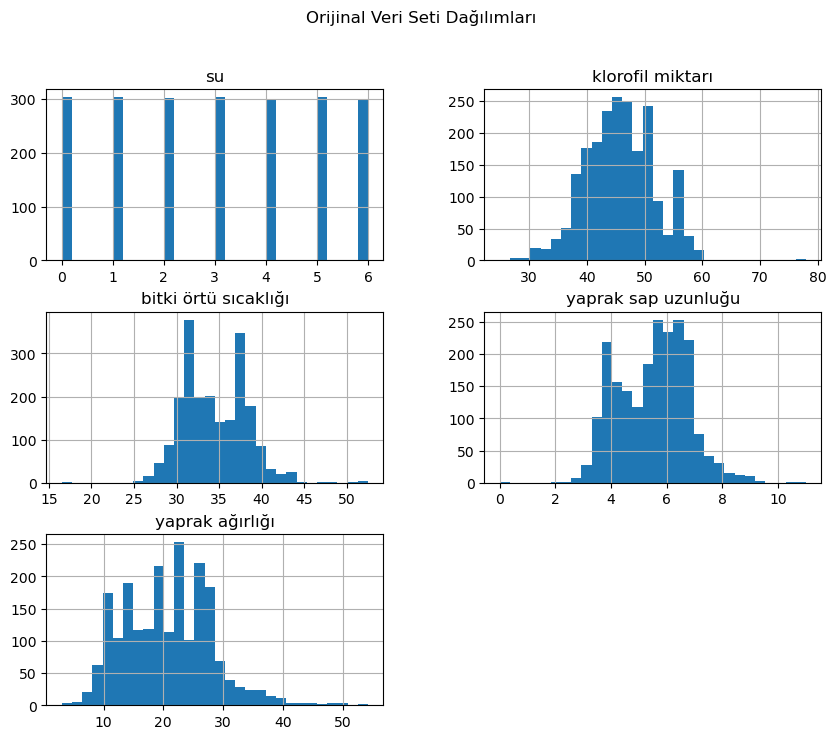

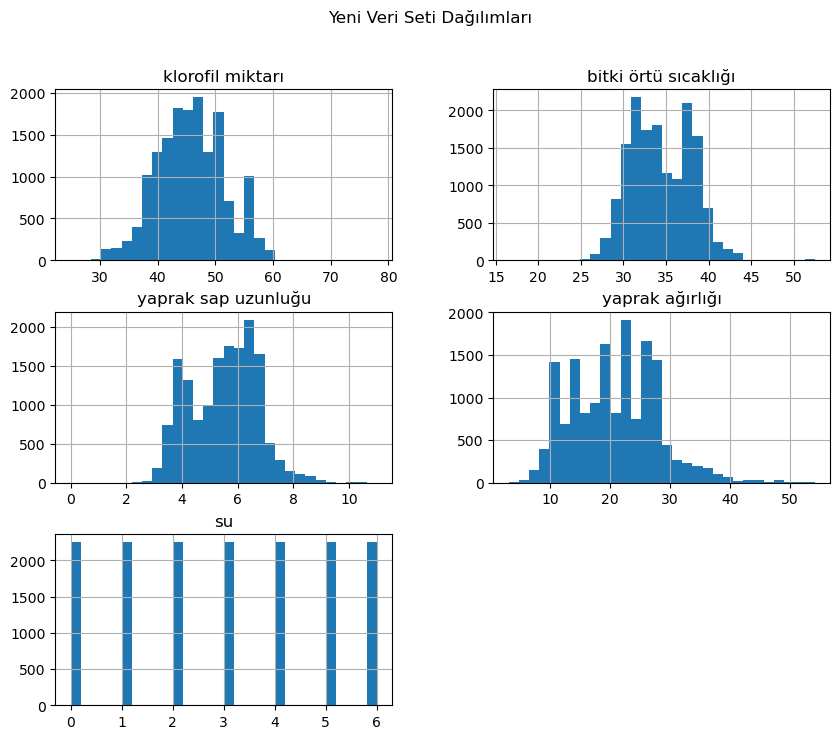

In [15]:
# Orijinal veri seti için histogram
df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Orijinal Veri Seti Dağılımları")
plt.show()

# Yeni veri seti için histogram
df_resampled.hist(figsize=(10, 8), bins=30)
plt.suptitle("Yeni Veri Seti Dağılımları")
plt.show()

In [16]:
df=df_resampled

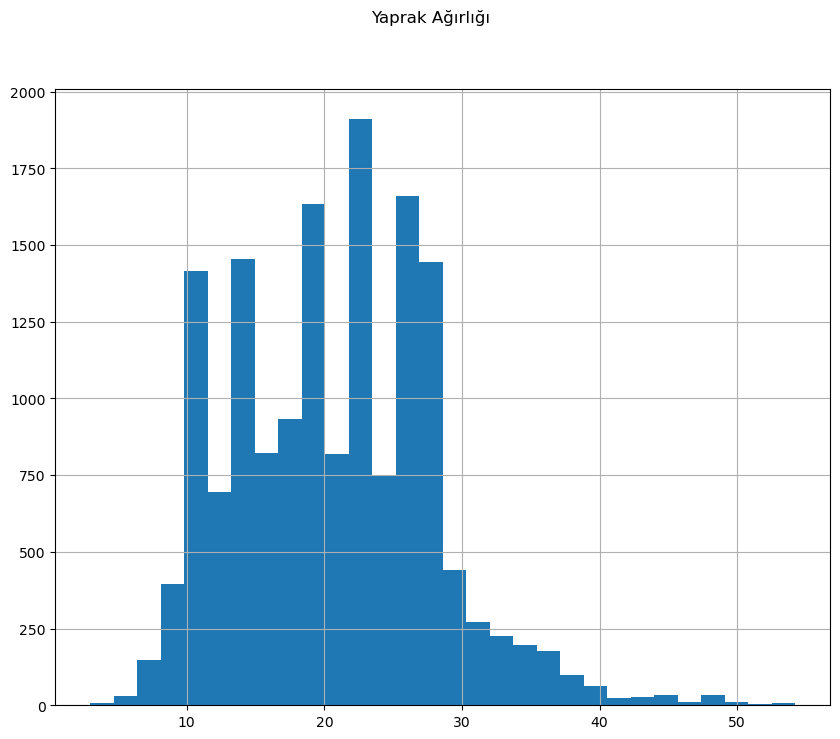

In [17]:
df["yaprak ağırlığı"].hist(figsize=(10, 8), bins=30)
plt.suptitle("Yaprak Ağırlığı")
plt.show()

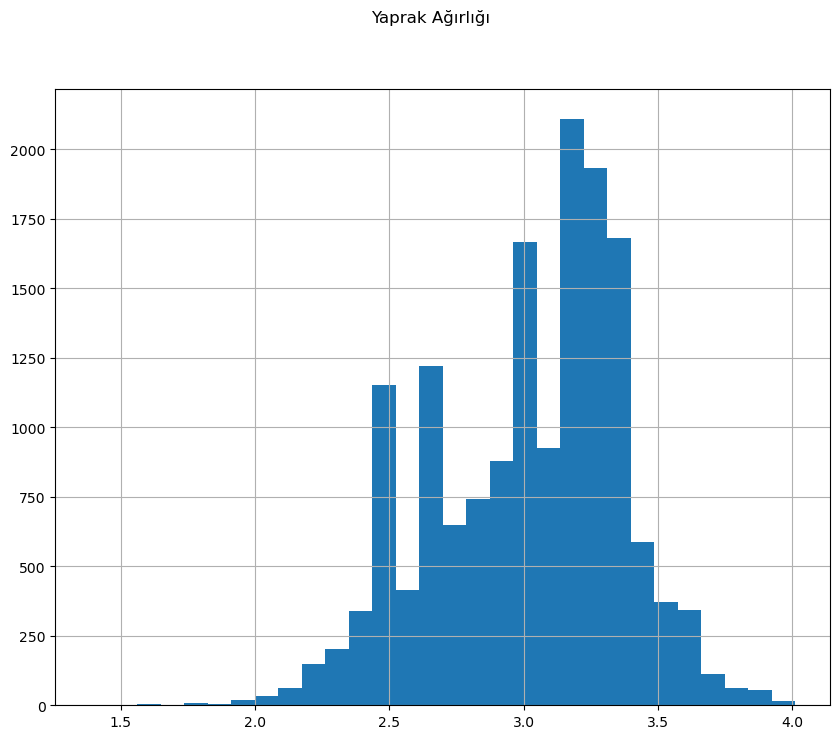

In [18]:
np.log1p(df['yaprak ağırlığı']).hist(figsize=(10, 8), bins=30)
plt.suptitle("Yaprak Ağırlığı")
plt.show()

In [19]:
X = df[['su', 'klorofil miktarı', 'bitki örtü sıcaklığı']]  # Bağımsız değişkenler
y = df[['yaprak sap uzunluğu', 'yaprak ağırlığı']]  # Bağımlı değişkenler

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# RandomForestRegressor modelini kullanarak MultiOutputRegressor oluşturuyoruz
model = XGBRegressor(n_estimators=100, random_state=42)
multi_output_model = MultiOutputRegressor(model)

# Modeli eğit
multi_output_model.fit(X_train, y_train)

# Test verisi ile tahmin yap
y_pred = multi_output_model.predict(X_test)

# Metrikleri hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.3502476215362549
Root Mean Squared Error (RMSE): 2.5663538539885407
R-squared (R²): 0.7891303300857544


In [20]:
df['klorofil_su_etkileşim'] = df['klorofil miktarı'] * (df['su'])

In [21]:
df['sıcaklık_su_oranı'] = df['bitki örtü sıcaklığı'] / (df['su'] + 1)

In [22]:
df["Klorofil_x_Sıcaklık"] = df["klorofil miktarı"] * df["bitki örtü sıcaklığı"]

In [23]:
df = pd.get_dummies(df, columns=["su"], prefix='su', dtype=int)

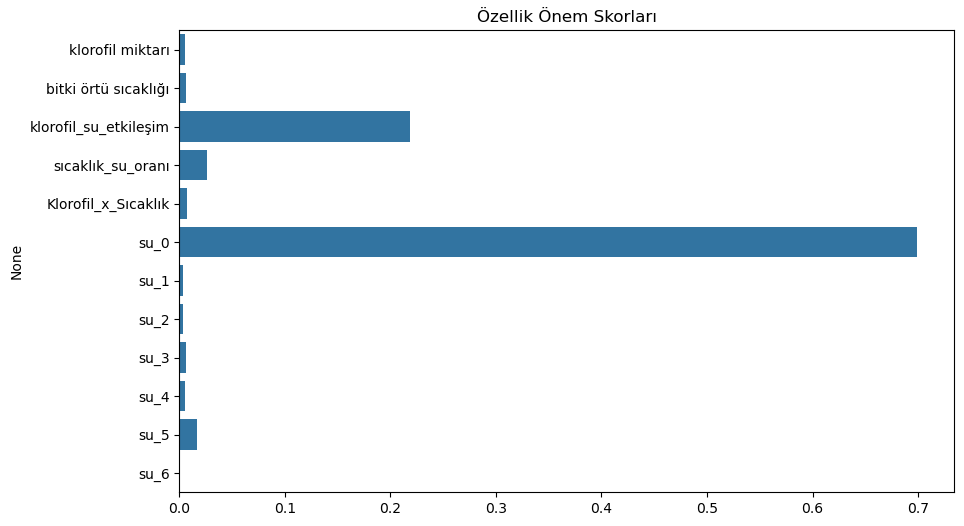

Mean Absolute Error (MAE): 1.2905454635620117
Root Mean Squared Error (RMSE): 2.544202842051212
R-squared (R²): 0.7990466356277466


In [24]:
# Bağımsız ve bağımlı değişkenleri ayır
X = df.drop(columns=['yaprak sap uzunluğu', 'yaprak ağırlığı'])
y = df[['yaprak sap uzunluğu', 'yaprak ağırlığı']]

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost modelini kullanarak MultiOutputRegressor oluştur
model = XGBRegressor(n_estimators=100, random_state=42)
multi_output_model = MultiOutputRegressor(model)

# Modeli eğit
multi_output_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = multi_output_model.predict(X_test)

# Özellik önemini görselleştir
feature_importances = multi_output_model.estimators_[0].feature_importances_  # İlk çıktı için önem
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title("Özellik Önem Skorları")
plt.show()

# Metrikleri hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

In [25]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)  # Bu bir numpy.ndarray döner

# Orijinal sütun isimlerini koruyarak yeniden pandas DataFrame'e çevirin
df = pd.DataFrame(df_scaled, columns=df.columns)
print(df.head())

   klorofil miktarı  bitki örtü sıcaklığı  yaprak sap uzunluğu  \
0             0.392                 0.458                0.300   
1             0.183                 0.431                0.309   
2             0.275                 0.708                0.318   
3             0.258                 0.458                0.373   
4             0.267                 0.431                0.318   

   yaprak ağırlığı  klorofil_su_etkileşim  sıcaklık_su_oranı  \
0            0.102                  0.000              0.660   
1            0.145                  0.000              0.638   
2            0.164                  0.000              0.864   
3            0.209                  0.000              0.660   
4            0.197                  0.000              0.638   

   Klorofil_x_Sıcaklık  su_0  su_1  su_2  su_3  su_4  su_5  su_6  
0                0.391 1.000 0.000 0.000 0.000 0.000 0.000 0.000  
1                0.198 1.000 0.000 0.000 0.000 0.000 0.000 0.000  
2                

In [26]:
# Korelasyon matrisini hesapla
correlation_matrix = df.corr()

# Bağımlı değişkenler ile diğer değişkenlerin korelasyonlarını çek
dependent_vars = ["yaprak ağırlığı", "yaprak sap uzunluğu"]

# Sadece bağımlı değişkenlerle diğer değişkenler arasındaki korelasyonları al
target_corr = correlation_matrix[dependent_vars].drop(dependent_vars)

# Sıralama (istenirse her sütunu ayrı ayrı sıralayabilirsiniz)
sorted_corr = target_corr.sort_values(by=dependent_vars, ascending=False)

print("Bağımlı değişkenlerle diğer değişkenlerin korelasyonları:\n", sorted_corr)


Bağımlı değişkenlerle diğer değişkenlerin korelasyonları:
                        yaprak ağırlığı  yaprak sap uzunluğu
klorofil_su_etkileşim            0.768                0.831
klorofil miktarı                 0.441                0.498
su_6                             0.423                0.428
su_5                             0.340                0.383
su_3                             0.154                0.116
su_4                             0.097                0.148
Klorofil_x_Sıcaklık              0.091                0.132
su_2                            -0.091               -0.065
su_1                            -0.375               -0.424
bitki örtü sıcaklığı            -0.409               -0.424
su_0                            -0.548               -0.586
sıcaklık_su_oranı               -0.735               -0.791


In [27]:
df.head()

,klorofil miktarı,bitki örtü sıcaklığı,yaprak sap uzunluğu,yaprak ağırlığı,klorofil_su_etkileşim,sıcaklık_su_oranı,Klorofil_x_Sıcaklık,su_0,su_1,su_2,su_3,su_4,su_5,su_6
0,0.392,0.458,0.300,0.102,0.000,0.660,0.391,1.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.183,0.431,0.309,0.145,0.000,0.638,0.198,1.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.275,0.708,0.318,0.164,0.000,0.864,0.464,1.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.258,0.458,0.373,0.209,0.000,0.660,0.278,1.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.267,0.431,0.318,0.197,0.000,0.638,0.267,1.000,0.000,0.000,0.000,0.000,0.000,0.000


In [28]:
# Bağımsız ve bağımlı değişkenleri ayır
X = df.drop(columns=["yaprak ağırlığı", "yaprak sap uzunluğu"])  # İki bağımlı değişken olduğunda, her ikisini de 'y' değişkeninden çıkarıyoruz.
y = df[['yaprak ağırlığı', 'yaprak sap uzunluğu']]  # Burada her iki bağımlı değişkeni dahil ediyoruz.

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost modelini kullanarak MultiOutputRegressor oluştur
xgb_model = XGBRegressor(
    n_estimators=1000,        
    learning_rate=0.01,       
    max_depth=8,              
    subsample=0.8,            
    colsample_bytree=0.8,     
    random_state=42
)

# MultiOutputRegressor ile model oluştur
multi_output_model = MultiOutputRegressor(xgb_model)

# Modeli eğit
multi_output_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = multi_output_model.predict(X_test)

# Metrikleri hesapla
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdır
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")


Mean Absolute Error (MAE): 0.03525187075138092
Root Mean Squared Error (RMSE): 0.056172035744958326
R-squared (R²): 0.8093571662902832


In [29]:
X = df.drop(columns=["yaprak ağırlığı", "yaprak sap uzunluğu"])
y = df[['yaprak ağırlığı', 'yaprak sap uzunluğu']]

# Log dönüşümü yap (her iki bağımlı değişken için)
y_log = np.log1p(y)

# Eğitim ve test verisi
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# XGBoost modelini kullanarak MultiOutputRegressor oluştur
xgb_model = XGBRegressor(
    n_estimators=1000,        
    learning_rate=0.01,       
    max_depth=8,              
    subsample=0.8,            
    colsample_bytree=0.8,     
    random_state=42
)

# MultiOutputRegressor ile model oluştur
multi_output_model = MultiOutputRegressor(xgb_model)

# Modeli eğit
multi_output_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred_log = multi_output_model.predict(X_test)

# Ters log dönüşümünü yap
y_pred_actual = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Metrikleri hesapla
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2 = r2_score(y_test_actual, y_pred_actual)

# Sonuçları yazdır
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.03503480926156044
Root Mean Squared Error (RMSE): 0.0559557541773067
R-squared (R²): 0.8106504678726196


In [30]:
# Veri setinde bağımsız ve bağımlı değişkenlerin ayrılması
X = df.drop(columns=["yaprak ağırlığı", "yaprak sap uzunluğu"])  # Bağımsız değişkenler
y = df[['yaprak ağırlığı', 'yaprak sap uzunluğu']]              # Orijinal bağımlı değişkenler

# Log dönüşümü (np.log1p: sıfır veya pozitif değerlere uygundur)
y_log = np.log1p(y)

# Eğitim ve test verisinin oluşturulması (burada log dönüşümlü y kullanılıyor)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# XGBoost regressor nesnesi
model = xgb.XGBRegressor(objective='reg:squarederror')

# MultiOutputRegressor ile model sarma
multi_output_model = MultiOutputRegressor(model)

# Hiperparametre aralıkları
param_distributions = {
    'estimator__alpha': uniform(0.1, 0.4),               # 0.1 ile 0.5 arasında sürekli değerler
    'estimator__lambda': uniform(0.1, 0.8),              # 0.1 ile 0.9 arasında sürekli değerler
    'estimator__n_estimators': randint(100, 1500),       # 100 ile 1500 arasında tamsayılar
    'estimator__max_depth': randint(6, 11),              # 6 ile 10 arasında tamsayılar
    'estimator__learning_rate': uniform(0.01, 0.09),     # 0.01 ile 0.1 arasında sürekli değerler
    'estimator__subsample': uniform(0.8, 0.2),           # 0.8 ile 1.0 arasında sürekli değerler
    'estimator__colsample_bytree': uniform(0.8, 0.2),    # 0.8 ile 1.0 arasında sürekli değerler
    'estimator__gamma': uniform(0, 0.2)                  # 0 ile 0.2 arasında sürekli değerler
}

# RandomizedSearchCV ile hiperparametre optimizasyonu
random_search = RandomizedSearchCV(
    estimator=multi_output_model,
    param_distributions=param_distributions,
    n_iter=50,                        # Denenecek rastgele kombinasyon sayısı
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Hiperparametre araması ile modeli eğit
random_search.fit(X_train, y_train)

# En iyi parametrelerin ve skorun yazdırılması
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Cross-Validation Score (MAE): {-random_search.best_score_}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'estimator__alpha': 0.42720590636899725, 'estimator__colsample_bytree': 0.9721461166512687, 'estimator__gamma': 0.0013904261062381408, 'estimator__lambda': 0.5085978420620526, 'estimator__learning_rate': 0.047566990283390106, 'estimator__max_depth': 10, 'estimator__n_estimators': 1348, 'estimator__subsample': 0.8239730734667366}
Best Cross-Validation Score (MAE): 0.027551402524113654


In [31]:
# En iyi parametrelerle yeni model oluşturma
best_model = MultiOutputRegressor(
    xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=random_search.best_params_['estimator__n_estimators'],
        max_depth=random_search.best_params_['estimator__max_depth'],
        learning_rate=random_search.best_params_['estimator__learning_rate'],
        alpha=random_search.best_params_['estimator__alpha'],
        reg_lambda=random_search.best_params_['estimator__lambda'],
        subsample=random_search.best_params_['estimator__subsample'],
        colsample_bytree=random_search.best_params_['estimator__colsample_bytree'],
        gamma=random_search.best_params_['estimator__gamma']
    )
)

# En iyi model ile eğitim
best_model.fit(X_train, y_train)

# Test seti üzerinde tahmin yapma (tahminler log ölçekli olacaktır)
y_pred_log = best_model.predict(X_test)

# Ters log dönüşümü ile orijinal ölçeğe çevirme
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Performans metriklerinin hesaplanması
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

# Sonuçların yazdırılması
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.037448491901159286
Root Mean Squared Error (RMSE): 0.057786490737048696
R-squared (R²): 0.7941576838493347
